# Flow Estimation

If you are running on Colab,
* Go to runtime -> change runtime type -> select "GPU" as the hardware accelerator. 

## Having Fun with Optical Flow

### ARFlow

Download the code for ARFlow from this link and install the requirements as recommended: https://github.com/lliuz/ARFlow

Make sure that you can run the inference.py without a problem before the next part.

If you could not install ARFlow on your local machine, you can follow these steps either on Colab or on your own machine to make it work:

Download the repository:

In [2]:
!wget https://github.com/lliuz/ARFlow/archive/master.zip

--2022-06-08 14:25:54--  https://github.com/lliuz/ARFlow/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lliuz/ARFlow/zip/refs/heads/master [following]
--2022-06-08 14:25:54--  https://codeload.github.com/lliuz/ARFlow/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [            <=>     ]  75.68M  14.9MB/s    in 5.1s    

2022-06-08 14:25:59 (14.9 MB/s) - ‘master.zip’ saved [79359531]



Unzip the repository:

In [3]:
!unzip master.zip

Archive:  master.zip
e92a8bbe66f0ced244267f43e3e55ad0fe46ff3e
   creating: ARFlow-master/
 extracting: ARFlow-master/.gitignore  
  inflating: ARFlow-master/Dockerfile  
  inflating: ARFlow-master/LICENSE   
  inflating: ARFlow-master/README.md  
  inflating: ARFlow-master/basic_train.py  
   creating: ARFlow-master/checkpoints/
   creating: ARFlow-master/checkpoints/CityScapes/
  inflating: ARFlow-master/checkpoints/CityScapes/pwclite_ar.tar  
   creating: ARFlow-master/checkpoints/KITTI12/
  inflating: ARFlow-master/checkpoints/KITTI12/pwclite_ar.tar  
  inflating: ARFlow-master/checkpoints/KITTI12/pwclite_ar_mv.tar  
   creating: ARFlow-master/checkpoints/KITTI15/
  inflating: ARFlow-master/checkpoints/KITTI15/pwclite_ar.tar  
  inflating: ARFlow-master/checkpoints/KITTI15/pwclite_ar_mv.tar  
  inflating: ARFlow-master/checkpoints/KITTI15/pwclite_raw.tar  
   creating: ARFlow-master/checkpoints/Sintel/
  inflating: ARFlow-master/checkpoints/Sintel/pwclite_ar.tar  
  inflating: ARFlo

Navigate to the repository:

In [2]:
cd ARFlow-master/

/content/ARFlow-master


From the menu on the left, open `models/pwclite.py` file, comment the 6th line and uncomment the 7th line.
Then, **if you are using Colab you should not run the next cell**. but if you are on your local machine, install the requirements:

In [ ]:
# !pip3 install -r requirements.txt

Now you should be able to run the following:

In [ ]:
!pwd

/Users/moayedhajiali/Desktop/Courses/CVAD/HW3/src/flow


examples/flow.npy


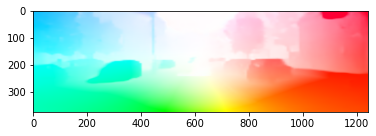

In [57]:
%run inference.py -m checkpoints/KITTI15/pwclite_ar.tar -s 384 640  --dest examples/flow.npy -i examples/img1.png examples/img2.png 

### Bullet Time Effect

In this question, you will estimate optical flow using ARFlow (or you can use some other flow method if you cannot make it work) and then use it to interpolate between two images. 

First, calculate the optical flow between two images, e.g. provided KITTI images in the example folder, using the ARFlow as illustrated by the example in inference.py. 
Then, synthesize 10 novel frames between the two images using linear interpolation. 

**Hint:** First, compute the flow and then divide it by the number of frames. Then, at each step, warp the image incrementally to obtain images in between. You can use OpenCV's `remap()` function for warping or have a look at the `flow_warp` in utils/warp_utils.py file of the ARFlow.

* Where does the interpolation work well and where does it fail? 
* Please also hand-in your interpolated images or create a small movie.


In [1]:
# load images
from PIL import Image
img1 = Image.open('examples/img1.png')
img2 = Image.open('examples/img2.png')
display(img1)
display(img2)

FileNotFoundError: ignored

In [59]:
# load optical flow
import numpy as np
optical_flow = np.load('examples/flow.npy')
optical_flow = torch.Tensor(optical_flow).permute(2, 0, 1).unsqueeze(0)
optical_flow.shape

torch.Size([1, 2, 375, 1242])

In [67]:
import torch
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])
x = transform(img1).unsqueeze(0)
x.shape

torch.Size([1, 3, 375, 1242])

In [68]:
# create frames with optical flow 
from utils.warp_utils import flow_warp
n_frames = 10
save_dir = 'video'
images = [img1]
img1.save(f'{save_dir}/img_{0}.png')
for i in range (1, n_frames-1):
  grid = flow_warp(x, - optical_flow * (i / n_frames))[0]
  grid = grid.transpose(0,1).transpose(1,2).squeeze(-1)
  grid = grid.numpy()
  grid = (grid*255).astype(np.uint8)
  img = Image.fromarray(grid)
  img.save(f'{save_dir}/img_{i}.png')
  images.append(img)
img2.save(f'{save_dir}/img_{n_frames-1}.png')
images.append(img2)

In [69]:
import os 
os.system(f"ffmpeg -r 1 -i {save_dir}/img_%01d.png -vcodec mpeg4 -y {save_dir}/movie.mp4")

0

### Multi-frame Bullet Time Sequence (Optional)

If you had fun with the previous question, you might want to extend this effect to several frames as in the original Matrix movie! 

Use consecutive images or capture several images along a smooth camera trajectory and smoothly vary the pose of the objects in between. 

Between each two adjacent frames, interpolate an additional 10 to 100 frames and concatenate all images to one long slow motion video sequence.

In [7]:
from utils.warp_utils import flow_warp
import torch
from torchvision import transforms
import numpy as np
transform = transforms.Compose([transforms.ToTensor()])

In [8]:
# get all images in frames 
import glob
imgs_paths = glob.glob("frames2/*.png")
imgs_paths = sorted(imgs_paths)
imgs_paths

['frames2/0000000000.png',
 'frames2/0000000001.png',
 'frames2/0000000002.png',
 'frames2/0000000003.png',
 'frames2/0000000004.png',
 'frames2/0000000005.png',
 'frames2/0000000006.png',
 'frames2/0000000007.png']

In [11]:
import os
inter_frames = 30
save_dir = 'final_video'
transform = transforms.Compose([transforms.ToTensor()])

# prepare input
x, flows = [], []
for (path1, path2) in zip(imgs_paths[:-1], imgs_paths[1:]):
  # extract optical flow 
  os.system(f"inference.py -m checkpoints/KITTI15/pwclite_ar.tar -s 384 640  --dest examples/flow.npy -i {path1} {path2}")

  optical_flow = np.load('examples/flow.npy')
  optical_flow = torch.Tensor(optical_flow).permute(2, 0, 1)
  # load two images
  img = Image.open(path1)
  print(img.size, optical_flow.shape)

  tmp = transform(img)
  for i in range(0, inter_frames):
    flows.append(-optical_flow * (i / inter_frames))
    x.append(tmp)


x = torch.stack(x)
flows = torch.stack(flows)
grids = flow_warp(x, flows)
print(grids.shape)
grids = grids.permute(0, 2, 3, 1)
grids = grids.numpy()
grids = (grids*255).astype(np.uint8)

# save images

for i, grid in enumerate(grids):
  img = Image.fromarray(grid[:, :, 0])
  img.save(f'{save_dir}/img_{i+1:03d}.png')

(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
(1242, 375) torch.Size([2, 375, 1242])
torch.Size([210, 1, 375, 1242])


In [12]:
import os 
os.system(f"ffmpeg -r 25 -i {save_dir}/img_%03d.png -vcodec mpeg4 -y {save_dir}/slow_mo.mp4")

0